In [3]:

import pickle

import category_encoders as ce
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.compose import ColumnTransformer, make_column_selector as selector
# from sklearn.impute import KNNImputer
from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

# import xgboost as xgb
# import lightgbm as lgb

In [7]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized_BE.parquet.gzip"
)
# test_data = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')
# test_data = pd.read_parquet('../data/processed/brave/08_12_2022/test_set_all_processed.parquet.gzip')

test_data = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data_featurized_BE.parquet.gzip')

In [41]:
len(train_data) / (2 * np.bincount(train_data['tracker']))

array([0.69857462, 1.75897257])

In [43]:
def calculate_metrics(data, y_true):
    y_pred = clf.predict(data)
    pred_probs = clf.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print(
        "Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred))
    )
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Model auc score : {0:0.4f}".format(auc_score))

    print(metrics.classification_report(y_test, y_pred))

    disp_1 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp_2 = metrics.PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, name="Random Forest"
    )
    disp_3 = metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
    # mlflow.log_figure(disp_1.figure_, "cm.png")
    # mlflow.log_figure(disp_2.figure_, "prec_recall.png")
    # mlflow.log_figure(disp_3.figure_, "roc.png")

In [8]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

del train_data
del test_data

In [24]:
clf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=10,
    criterion="log_loss",
    max_features=None,
)

# clf = DecisionTreeClassifier()
# clf = GradientBoostingClassifier()
# clf = xgb.XGBClassifier()
# clf = lgb.LGBMClassifier(class_weight="balanced")
# clf = MLPClassifier()
# clf = LogisticRegression(n_jobs=-1, random_state=10)
# clf = GaussianNB()

In [3]:
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)
# warnings.filterwarnings("ignore")
#
# with open("../params.yaml", "rb") as f:
#     params = yaml.safe_load(f)
#
# mlflow.set_tracking_uri(params["ml_flow"]["MLFLOW_TRACKING_URI"])
# os.environ["MLFLOW_TRACKING_USERNAME"] = params["ml_flow"][
#     "MLFLOW_TRACKING_USERNAME"
# ]
# os.environ["MLFLOW_TRACKING_PASSWORD"] = params["ml_flow"][
#     "MLFLOW_TRACKING_PASSWORD"
# ]
#
# mlflow.set_experiment("all_binary_firefox_experiments")
# mlflow.sklearn.autolog()
# mlflow.xgboost.autolog()
# mlflow.lightgbm.autolog()

In [ ]:
# logged_model = 'runs:/c210d5dc13a641f68fd5feff177ebe8b/model'
# # Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)

Model accuracy score : 0.9238
Balanced accuracy score : 0.9035
F1 score : 0.8535
Model log-loss score : 0.4956
Matthews correlation coefficient score : 0.8021
Precision score : 0.8456
Recall score : 0.8616
Model auc score : 0.9035
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    596066
           1       0.85      0.86      0.85    206747

    accuracy                           0.92    802813
   macro avg       0.90      0.90      0.90    802813
weighted avg       0.92      0.92      0.92    802813



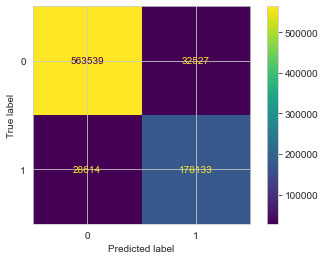

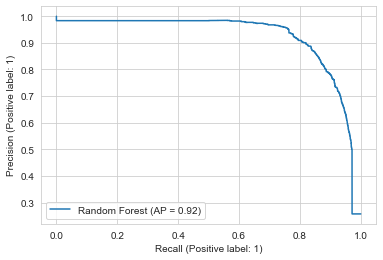

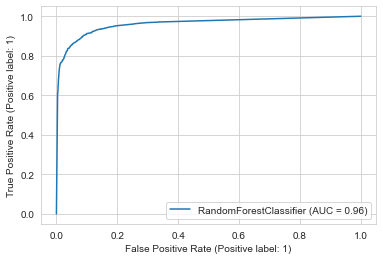

In [25]:
clf.fit(X_train, y_train["tracker"])
calculate_metrics(X_test, y_test)

\footnote{. \url{}, [Accessed Jan. 31, 2023]}

In [3]:
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

In [95]:
models = {
    # "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=10, criterion="gini",
    #                                         max_features=None),
    # "KNN": KNeighborsClassifier(n_jobs=-1),
    "Decision_Tree": DecisionTreeClassifier(random_state=10),
    # "Gradient Boosting": GradientBoostingClassifier(random_state=10),
    # "Hist Gradient Boosting": HistGradientBoostingClassifier(
    #         random_state=10, class_weight="balanced"
    #     ),
    # "XGBoost": XGBClassifier(random_state=10, use_label_encoder=False, eval_metric="logloss"),
    # "LightGBM": LGBMClassifier(random_state=10, class_weight="balanced"),
    # "CatBoost": CatBoostClassifier(random_state=10, verbose=0),
    # "MLP": MLPClassifier(random_state=10),
    "Logistic_Regression": LogisticRegression(random_state=10, max_iter=1000, solver='newton-cholesky'),
    # "Gaussian NB": GaussianNB()
}

In [5]:
from typing import Dict, List, Tuple

In [6]:
def calculate_metrics(
        y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "log_loss": score,
        "auc": auc_score,
        "balanced_accuracy": bal_acc,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
    }

In [60]:
# def perform_cross_validation(
#     X: pd.DataFrame, y: pd.Series, clf: Pipeline, cv: StratifiedKFold
# ) -> List[Dict[str, float]]:
#     all_metrics = []
#
#     for train_idx, test_idx in cv.split(X, y):
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
#
#         clf.fit(X_train, y_train)
#         y_pred = clf.predict(X_test)
#         y_pred_proba = clf.predict_proba(X_test)[:, 1]
#
#         fold_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
#         all_metrics.append(fold_metrics)
#
#     return all_metrics
#
#
# def mean_metrics(all_metrics: List[Dict[str, float]]) -> Dict[str, float]:
#     return {
#         metric: np.mean([fold_metrics[metric] for fold_metrics in all_metrics])
#         for metric in all_metrics[0].keys()
#     }

In [65]:
# def train_and_evaluate_models(
#     models: Dict[str, BaseEstimator],
#     X: pd.DataFrame,
#     y: pd.Series,
#     cv: StratifiedKFold,
#     # preprocessor: ColumnTransformer,
# ) -> pd.DataFrame:
#     all_mean_metrics = {}
#
#     for model_name, model in models.items():
#         print(f"Training and evaluating {model_name}...")
#
#         clf = Pipeline(steps=[("classifier", model)])
#         all_metrics = perform_cross_validation(X, y, clf, cv)
#         mean_metrics_values = mean_metrics(all_metrics)
#
#         all_mean_metrics[model_name] = mean_metrics_values
#
#     return pd.DataFrame(all_mean_metrics).T

In [55]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import BaseCrossValidator


def calculate_metrics(
        y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    """
    Calculate classification metrics for a given set of true labels and
    predictions.

    Parameters
    ----------
    y_true : pd.Series
        The true labels for the test set.
    y_pred : np.ndarray
        The predicted labels for the test set.
    y_pred_proba : np.ndarray
        The predicted probabilities for the positive class.

    Returns
    -------
    dict
        A dictionary containing various classification metrics.
    """
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": np.round(metrics.accuracy_score(y_true, y_pred), 3),
        "log_loss": np.round(score, 3),
        "auc": np.round(auc_score, 3),
        "balanced_accuracy": np.round(bal_acc, 3),
        "f1": np.round(f1_score, 3),
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "mcc": np.round(mcc, 3),
    }


def calculate_confusion_matrix_elements(
        y_true: pd.Series, y_pred: np.ndarray
) -> Dict[str, int]:
    """
    Calculate the confusion matrix elements (FP, TN, FN, TP) for the given true
    and predicted values.

    Parameters
    ----------
    y_true : pd.Series
        True target values.
    y_pred : np.ndarray
        Predicted target values.

    Returns
    -------
    Dict[str, int]
        A dictionary containing the confusion matrix elements (FP, TN, FN, TP).
    """
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    print(type(fn))
    return {"FP": int(fp), "TN": int(tn), "FN": int(fn), "TP": int(tp)}


def train_and_evaluate_models_2(
        models: Dict[str, BaseEstimator],
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame,
        y_test: pd.Series,
        cv: BaseCrossValidator,
        clf_preprocessor: ColumnTransformer = None,
) -> pd.DataFrame:
    all_mean_metrics = {}
    scoring_metrics = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "f1": "f1",
        "balanced_accuracy": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
        "neg_log_loss": "neg_log_loss",
        "mcc": make_scorer(matthews_corrcoef),
    }

    for model_name, model in models.items():
        print(f"Training and evaluating {model_name}...")

        if type(clf_preprocessor) is not None:
            clf_pipeline = Pipeline(
                steps=[("preprocessor", clf_preprocessor), ("classifier", model)]
            )
        else:
            clf_pipeline = Pipeline(steps=[("classifier", model)])

        cv_results = cross_validate(
            clf_pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring_metrics,
            return_estimator=True,
            n_jobs=-1,
        )
        mean_cv_metrics = {
            metric: np.mean(cv_results["test_" + metric])
            for metric in scoring_metrics.keys()
        }

        best_estimator_idx = np.argmax(cv_results["test_roc_auc"])
        best_estimator = cv_results["estimator"][best_estimator_idx]

        # filename = "random_forest_v3_binary.sav"
        # pickle.dump(clf['classifier'], open(f'../../../models/chrome/08_12_2022/{filename}', 'wb'))

        y_pred_test = best_estimator.predict(X_test)
        y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]

        test_metrics = calculate_metrics(y_test, y_pred_test, y_pred_proba_test)
        test_metrics.update(calculate_confusion_matrix_elements(y_test, y_pred_test))

        mean_cv_metrics.update({"test_" + k: v for k, v in test_metrics.items()})
        all_mean_metrics[model_name] = mean_cv_metrics

    return pd.DataFrame(all_mean_metrics).T
    # return best_estimator


def train_models(
        models: Dict[str, BaseEstimator],
        X_train: pd.DataFrame,
        y_train: pd.Series,
        cv: BaseCrossValidator,
        clf_preprocessor: ColumnTransformer = None,
) -> pd.DataFrame:
    all_mean_metrics = {}
    scoring_metrics = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "f1": "f1",
        "balanced_accuracy": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
        "neg_log_loss": "neg_log_loss",
        "mcc": make_scorer(matthews_corrcoef),
    }

    for model_name, model in models.items():
        print(f"Training and evaluating {model_name}...")

        if type(clf_preprocessor) is not None:
            clf_pipeline = Pipeline(
                steps=[("preprocessor", clf_preprocessor), ("classifier", model)]
            )
        else:
            clf_pipeline = Pipeline(steps=[("classifier", model)])

        cv_results = cross_validate(
            clf_pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring_metrics,
            return_estimator=True,
            n_jobs=-1,
        )
        mean_cv_metrics = {
            metric: np.round(np.mean(cv_results["test_" + metric]), 3)
            for metric in scoring_metrics.keys()
        }
        all_mean_metrics[model_name] = mean_cv_metrics

        best_estimator_idx = np.argmax(cv_results["test_roc_auc"])
        best_estimator = cv_results["estimator"][best_estimator_idx]

        filename = f"{model_name}_binary.sav"
        pickle.dump(
            best_estimator["classifier"],
            open(f"../models/chrome/08_12_2022/{filename}", "wb"),
        )

    return pd.DataFrame(all_mean_metrics).T

In [68]:
from joblib import Parallel, delayed

In [114]:
def calculate_single_bootstrap_sample(y_true, y_pred, y_pred_proba, random_state):
    sample_idx = random_state.choice(len(y_true), len(y_true), replace=True)
    y_true_sample = y_true.iloc[sample_idx]
    y_pred_sample = y_pred[sample_idx]
    y_pred_proba_sample = y_pred_proba[sample_idx]

    return calculate_metrics(y_true_sample, y_pred_sample, y_pred_proba_sample)


def calculate_confidence_intervals(
        y_true: pd.Series,
        y_pred: np.ndarray,
        y_pred_proba: np.ndarray,
        n_bootstrap_samples: int = 10,
        random_state: int = 10,
        n_jobs: int = -1,
) -> Dict[str, Tuple[float, float]]:
    rng = np.random.RandomState(random_state)
    random_states = [
        np.random.RandomState(rng.randint(np.iinfo(np.int32).max))
        for _ in range(n_bootstrap_samples)
    ]

    bootstrap_metrics = Parallel(n_jobs=n_jobs)(
        delayed(calculate_single_bootstrap_sample)(y_true, y_pred, y_pred_proba, rs)
        for rs in random_states
    )

    confidence_intervals = {}
    for metric in bootstrap_metrics[0].keys():
        sorted_bootstrap_values = sorted(
            [sample_metrics[metric] for sample_metrics in bootstrap_metrics]
        )
        ci_lower = np.round(np.percentile(sorted_bootstrap_values, 2.5), 3)
        ci_upper = np.round(np.percentile(sorted_bootstrap_values, 97.5), 3)
        confidence_intervals[metric + "_CI"] = (ci_lower, ci_upper)

    return confidence_intervals

In [110]:
def test_models(
        models: List[str],
        X_test: pd.DataFrame,
        y_test: pd.Series,
) -> List[pd.DataFrame]:
    all_mean_metrics = {}
    ci_results = {}

    for model_name in models:
        print(f"Evaluating {model_name}...")

        filename = f"{model_name}_binary.sav"
        with open(f"../models/chrome/08_12_2022/{filename}", "rb") as f:
            best_estimator = pickle.load(f)

        y_pred_test = best_estimator.predict(X_test)
        y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]

        confidence_intervals = calculate_confidence_intervals(
            y_test, y_pred_test, y_pred_proba_test
        )

        ci_results[model_name] = confidence_intervals

        test_metrics = calculate_metrics(y_test, y_pred_test, y_pred_proba_test)
        test_metrics.update(calculate_confusion_matrix_elements(y_test, y_pred_test))

        final_metrics = {}
        final_metrics.update({"test_" + k: v for k, v in test_metrics.items()})
        all_mean_metrics[model_name] = final_metrics

    data = {model_name: {} for model_name in models}
    for model_name, ci in ci_results.items():
        for metric, bounds in ci.items():
            lower_key = f"{metric}_lower"
            upper_key = f"{metric}_upper"
            data[model_name][lower_key] = bounds[0]
            data[model_name][upper_key] = bounds[1]

    ci_df = pd.DataFrame.from_dict(data, orient='index')

    return [pd.DataFrame(all_mean_metrics).T, ci_df]

In [39]:
# from sklearn.model_selection import (
#     StratifiedShuffleSplit,
# )

In [7]:
# split = StratifiedShuffleSplit(n_splits=1, random_state=10, test_size=0.2)
split2 = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

In [58]:
split3 = RepeatedStratifiedKFold(random_state=10, n_splits=5, n_repeats=5)

In [ ]:
# %%time
# train_and_evaluate_models(models, X_train, y_train['tracker'], split2)

In [98]:
%%time
train_models(models, X_train, y_train['tracker'], split2)

Training and evaluating Decision_Tree...
Training and evaluating Logistic_Regression...


KeyboardInterrupt: 

In [115]:
%%time
a = test_models(['Logistic_Regression', 'Decision_Tree'], X_test, y_test['tracker'])

Evaluating Logistic_Regression...
<class 'numpy.int64'>
Evaluating Decision_Tree...
<class 'numpy.int64'>
CPU times: user 3 s, sys: 3.21 s, total: 6.21 s
Wall time: 5.99 s


In [112]:
a[0]

,test_accuracy,test_log_loss,test_auc,test_balanced_accuracy,test_f1,test_precision,test_recall,test_mcc,test_FP,test_TN,test_FN,test_TP
Logistic_Regression,0.892,0.252,0.855,0.855,0.787,0.796,0.779,0.715,41224.0,554842.0,45725.0,161022.0
Decision_Tree,0.917,1.853,0.896,0.896,0.840,0.828,0.852,0.784,36481.0,559585.0,30535.0,176212.0


In [116]:
a[1]

,accuracy_CI_lower,accuracy_CI_upper,log_loss_CI_lower,log_loss_CI_upper,auc_CI_lower,auc_CI_upper,balanced_accuracy_CI_lower,balanced_accuracy_CI_upper,f1_CI_lower,f1_CI_upper,precision_CI_lower,precision_CI_upper,recall_CI_lower,recall_CI_upper,mcc_CI_lower,mcc_CI_upper
Logistic_Regression,0.891,0.892,0.251,0.253,0.854,0.856,0.854,0.856,0.786,0.789,0.794,0.797,0.777,0.781,0.713,0.717
Decision_Tree,0.916,0.917,1.841,1.869,0.895,0.896,0.895,0.896,0.840,0.841,0.827,0.829,0.851,0.854,0.783,0.785


In [80]:
%%time
test_models(['Logistic Regression'], X_test, y_test['tracker'])

Evaluating Logistic Regression...
   accuracy_CI  log_loss_CI  auc_CI  balanced_accuracy_CI  f1_CI   
0        0.891        0.251   0.854                 0.854  0.786  \
1        0.892        0.253   0.856                 0.856  0.789   

   precision_CI  recall_CI  mcc_CI  
0         0.795      0.777   0.713  
1         0.798      0.780   0.716  
<class 'numpy.int64'>
CPU times: user 3.7 s, sys: 2.67 s, total: 6.37 s
Wall time: 1min 19s


,test_FN,test_FP,test_TN,test_TP,test_accuracy,test_auc,test_balanced_accuracy,test_f1,test_log_loss,test_mcc,test_precision,test_recall
Logistic Regression,45725.0,41224.0,554842.0,161022.0,0.892,0.855,0.855,0.787,0.252,0.715,0.796,0.779


In [38]:
filename = "Decision_Tree_binary.sav"
with open(f"../models/chrome/08_12_2022/{filename}", "rb") as f:
    best_estimator = pickle.load(f)

In [40]:
best_estimator.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [11]:
%%time
train_and_evaluate_models_2(models, X_train, y_train['tracker'], X_test, y_test['tracker'], split3)

NameError: name 'split3' is not defined

In [22]:
%%time
train_and_evaluate_models_2(models, X_train, y_train['tracker'], X_test, y_test['tracker'], split2)

Training and evaluating Random Forest...
CPU times: user 15.2 s, sys: 1.48 s, total: 16.6 s
Wall time: 1min 3s


,accuracy,balanced_accuracy,f1,mcc,neg_log_loss,precision,recall,roc_auc,test_FN,test_FP,test_TN,test_TP,test_accuracy,test_auc,test_balanced_accuracy,test_f1,test_log_loss,test_mcc,test_precision,test_recall
Random Forest,0.964989,0.953056,0.937606,0.913435,-0.130888,0.95014,0.9254,0.992407,29064.0,31252.0,564814.0,177683.0,0.924869,0.903496,0.903496,0.854899,0.491768,0.804233,0.850422,0.859422


In [20]:
y_pred_test = model['classifier'].predict(X_test)
y_pred_proba_test = model['classifier'].predict_proba(X_test)[:, 1]
test_metrics = calculate_metrics(y_test, y_pred_test, y_pred_proba_test)
print(test_metrics)

{'accuracy': 0.9248691787502196, 'log_loss': 0.4917676276513927, 'auc': 0.9034959751293761, 'balanced_accuracy': 0.9034959751293761, 'f1': 0.8548986965998047, 'precision': 0.8504223801660804, 'recall': 0.8594223858145463, 'mcc': 0.8042327760644166}


In [24]:
type(model['classifier'])

sklearn.ensemble._forest.RandomForestClassifier

In [ ]:
filename = "random_forest_v2_binary.sav"
pickle.dump(clf['classifier'], open(f'../../../models/chrome/08_12_2022/{filename}', 'wb'))

In [19]:
with open('../models/chrome/08_12_2022/lgbm_binary.sav', "rb") as f:
    model = pickle.load(f)

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
X_train

,comb_col_non_tracker,comb_col_tracker,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
0,0,0,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,5,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272000,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
272001,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272002,1,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
model.feature_importances_

array([62, 33, 69, 79, 52, 65, 25, 52, 92, 22, 69, 99, 66, 68,  2, 65, 63,
       37, 22, 75, 59, 34, 16,  9, 67,  9,  2,  5,  0, 45, 29, 32, 12, 22,
       40, 69, 97, 34, 35, 85, 51, 32, 19, 87, 37, 52, 26, 75, 22, 27, 94,
       18, 18, 55, 11, 21, 11, 15, 10,  0,  8, 10, 17,  9, 21, 19,  0,  9,
       26,  7,  6, 12,  3, 11, 25,  3,  1, 18,  1,  4,  4,  1, 10, 16,  2,
        0,  2,  2, 15,  0, 10, 11,  0,  1, 25,  1, 22,  6,  2,  0,  0,  0,
        0, 20, 18,  5,  2,  6,  0, 13,  5,  0,  0, 13,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  2,  3,  0, 11, 10,  9,  0,  9,  2,  1,  3,
        0,  0,  6,  2,  1,  0,  4,  0,  0,  7,  5,  0,  3,  0],
      dtype=int32)

In [ ]:
filename = "random_forest_v2_binary.sav"
pickle.dump(clf['classifier'], open(f'../../../models/chrome/08_12_2022/{filename}', 'wb'))

# ANCIENT CODE

In [118]:
firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')

In [119]:
firefox

,hostname,pathname,filetype,filename,date,content-type,content-length,cache-control,content-disposition,etag,...,x-via-ssl,request-time,access-control-request-method,fss-proxy,x-dc,x-llid,x-b3-sampled,tracker,comb_col_non_tracker,comb_col_tracker
0,vuukle.com,/a3a95d10e1d03fe77d6b.png,png,a3a95d10e1d03fe77d6b.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,15780,"public, max-age=7200","inline; filename=""a3a95d10e1d03fe77d6b.webp""","""a76e19b58c5103936ca99a64e6c1d71d""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
1,vuukle.com,/589.1b85456a4e062e8d6232.js,js,589.1b85456a4e062e8d6232.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,1539,"public, max-age=7200",NaN,"w/""573591b2d822f76e9fa661dcdc83c284""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0
2,vuukle.com,/29eab20501ed73f16eba.jpg,jpg,29eab20501ed73f16eba.jpg,"fri, 12 aug 2022 22:10:52 gmt",image/webp,9952,"public, max-age=7200","inline; filename=""29eab20501ed73f16eba.webp""","""97fe776c2cbd2cbaa24192f89eaefc74""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
3,vuukle.com,/22ab1ea08fc1962409f1.png,png,22ab1ea08fc1962409f1.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,41109,"public, max-age=7200","inline; filename=""22ab1ea08fc1962409f1.webp""","""6193272dc9caf2486c404218e1380542""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
4,cookie-cdn.cookiepro.com,/scripttemplates/6.19.0/otTCF.js,js,otTCF.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,<NA>,"public, max-age=14400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498363,nt.global.ssl.fastly.net,/images/1431839055959-1428713.jpg,jpg,1431839055959-1428713.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,230,NaN,inline;filename=1428713.jpg;filename*=utf-8''1...,"""lp0kw1rx62w0lmnah1yusy/dyxtczm9x1svbssqydcu""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
498364,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498365,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498366,nt.global.ssl.fastly.net,/images/1431846945741-petworthbeautiesbeautyro...,jpg,1431846945741-petworthbeautiesbeautyroom.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,206,NaN,inline;filename=petworthbeauties_beautyroom.jp...,"""a+x3kgq0g9qfmdlswkdp6yvat8wg4xh1vd6lv4reg+o""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0


In [121]:
X_test

,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,x-robots-tag_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
0,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564658,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564659,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564660,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564661,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip"
)
# X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]

In [ ]:
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
)
# X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [2]:
from typing import Dict, List
from sklearn.model_selection import StratifiedKFold

In [35]:
def calculate_metrics(y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, float]:
    """
    Calculate classification metrics for a given set of true labels and predictions.

    Parameters
    ----------
    y_true : pd.Series
        The true labels for the test set.
    y_pred : np.ndarray
        The predicted labels for the test set.
    y_pred_proba : np.ndarray
        The predicted probabilities for the positive class.

    Returns
    -------
    dict
        A dictionary containing various classification metrics.
    """
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "log_loss": score,
        "auc": auc_score,
        "balanced_accuracy": bal_acc,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
    }


def perform_cross_validation(X: pd.DataFrame, y: pd.Series, clf: Pipeline, cv: StratifiedKFold) -> List[
    Dict[str, float]]:
    """
    Perform cross-validation for a given classifier and dataset.

    Parameters
    ----------
    X : pd.DataFrame
        The feature matrix.
    y : pd.Series
        The target vector.
    clf : Pipeline
        The classifier pipeline.
    cv : StratifiedKFold
        The cross-validator providing train/test indices for each fold.

    Returns
    -------
    list
        A list of dictionaries containing classification metrics for each fold.
    """
    all_metrics = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        fold_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
        all_metrics.append(fold_metrics)

    return all_metrics


def mean_metrics(all_metrics: List[Dict[str, float]]) -> Dict[str, float]:
    """
    Compute the mean values of classification metrics across folds.

    Parameters
    ----------
    all_metrics : list
        A list of dictionaries containing classification metrics for each fold.

    Returns
    -------
    dict
        A dictionary containing the mean values of classification metrics.
    """
    return {
        metric: np.mean([fold_metrics[metric] for fold_metrics in all_metrics])
        for metric in all_metrics[0].keys()
    }

In [8]:
X, y = train_data.iloc[:, :-1], train_data["tracker"]

In [9]:
model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=10,
    criterion="gini",
    max_features=None,
)

In [10]:
numeric_transformer = Pipeline(
    steps=[("scaler", FunctionTransformer(np.log1p))]
)
norm_transformer = Pipeline(steps=[("norm_scaler", Normalizer())])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", ce.WOEEncoder(), selector(dtype_include="category")),
        ("num", numeric_transformer, ["content-length"]),
        ("age", norm_transformer, ["age"]),
    ]
)

In [11]:
clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

In [12]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa8ab8b0340>),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('age',
                                                  Pipeline(steps=[('norm_scaler',
                                                                   Normalizer())]),
                                                  ['age'])])),
                ('classifier',
                 RandomForestClassifier(max_features=None, n_jobs=-1,
                                        random_state=10))])

In [13]:
%%time
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

CPU times: user 5min 9s, sys: 2.81 s, total: 5min 12s
Wall time: 54.7 s


In [16]:
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
)
X_test_data, y_test_data = test_data.iloc[:, :-1], test_data[["tracker"]]

In [18]:
all_metrics = perform_cross_validation(X, y, clf, cv)

In [14]:
mean_metrics = mean_metrics(all_metrics)

In [19]:
print("Mean metrics across the folds:")
for metric, value in mean_metrics.items():
    print(f"{metric}: {value:.4f}")

Mean metrics across the folds:
accuracy: 0.9999
log_loss: 0.0016
auc: 0.9999
balanced_accuracy: 0.9999
f1: 0.9998
precision: 0.9999
recall: 0.9998
mcc: 0.9998


In [23]:
%%time
final_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model)])  # Replace 'model' with your chosen model
final_model.fit(X, y)  # Assuming X_train and y_train are your training data

CPU times: user 34 s, sys: 251 ms, total: 34.3 s
Wall time: 6.23 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa8ab8b0340>),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('age',
                                                  Pipeline(steps=[('norm_scaler',
                                                                   Normalizer())]),
                                                  ['age'])])),
                ('classifier',
                 RandomForestClassifier(max_features=None, n_jobs=-1,
                                        random_state=10))])

In [30]:
y_test_pred = final_model.predict(X_test_data)
y_test_pred_proba = final_model.predict_proba(X_test_data)

In [32]:
calculate_metrics(y_test_data, y_test_pred, y_test_pred_proba)

{'accuracy': 0.9999264716695343,
 'log_loss': 0.0016761614843792978,
 'auc': 0.9999174477689411,
 'balanced_accuracy': 0.9999174477689411,
 'f1': 0.9998706707017408,
 'precision': 0.9998448088562413,
 'recall': 0.9998965338851526,
 'mcc': 0.9998193055376092}

In [42]:
def calculate_metrics_2(data, y_true):
    y_pred = clf.predict(data)
    pred_probs = clf.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print(
        "Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test_data, y_pred))
    )
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Model auc score : {0:0.4f}".format(auc_score))
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print(metrics.classification_report(y_test_data, y_pred))

In [44]:
calculate_metrics_2(X_test_data, y_test_data)

Model accuracy score : 0.9999
Model log-loss score : 0.0017
Model auc score : 0.9999
Balanced accuracy score : 0.9999
F1 score : 0.9999
Precision score : 0.9998
Recall score : 0.9999
Matthews correlation coefficient score : 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48671
           1       1.00      1.00      1.00     19330

    accuracy                           1.00     68001
   macro avg       1.00      1.00      1.00     68001
weighted avg       1.00      1.00      1.00     68001



In [45]:
list(
    train_data.select_dtypes("category").columns.values.tolist()
)

['content-type',
 'accept-ranges',
 'etag',
 'vary',
 'content-encoding',
 'cache-control',
 'expires',
 'server',
 'alt-svc',
 'cross-origin-resource-policy',
 'access-control-allow-origin_cumulative']

In [9]:
import gzip

In [33]:
filename = f"LightGBM_BE.sav.gz"
filename1 = f"Random_Forest_BE.sav.gz"
filename2 = f"Logistic_Regression_BE.sav.gz"
filename3 = f"Hist_GB_BE.sav.gz"
filename4 = f"Ada_Boost_BE.sav.gz"
filename5 = f"Decision_Tree_BE.sav.gz"
filename6 = f"Extra_Trees_Classifier_BE.sav.gz"
filename7 = f"XGBoost_BE.sav.gz"
filename8 = f"Gradient_Boosting_BE.sav.gz"
filename9 = f"Gaussian_NB_BE.sav.gz"
filename10 = f"Bernoulli_NB_BE.sav.gz"

In [34]:
with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename}", "rb") as f:
    lgbm = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename1}", "rb") as f:
    rfc = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename2}", "rb") as f:
    lr = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename3}", "rb") as f:
    hgb = pickle.load(f)

# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename4}", "rb") as f:
#     ada = pickle.load(f)
#
# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename5}", "rb") as f:
#     dt = pickle.load(f)
#
# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename6}", "rb") as f:
#     et = pickle.load(f)
#
# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename7}", "rb") as f:
#     xgb = pickle.load(f)
#
# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename8}", "rb") as f:
#     gb = pickle.load(f)
#
# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename9}", "rb") as f:
#     gnb = pickle.load(f)
#
# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename10}", "rb") as f:
#     nb = pickle.load(f)

In [35]:
clf_list = [
    (lr, "Logistic"),
    (hgb, "HGB"),
    (lgbm, "LGBM"),
    (rfc, "Random forest"),
]

In [36]:
clf_list

[(LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                     random_state=10, solver='newton-cholesky'),
  'Logistic'),
 (HistGradientBoostingClassifier(class_weight='balanced', random_state=10),
  'HGB'),
 (LGBMClassifier(random_state=10), 'LGBM'),
 (RandomForestClassifier(class_weight='balanced', max_features=None, n_jobs=-1,
                         random_state=10),
  'Random forest')]

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_70210/2008148767.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pre

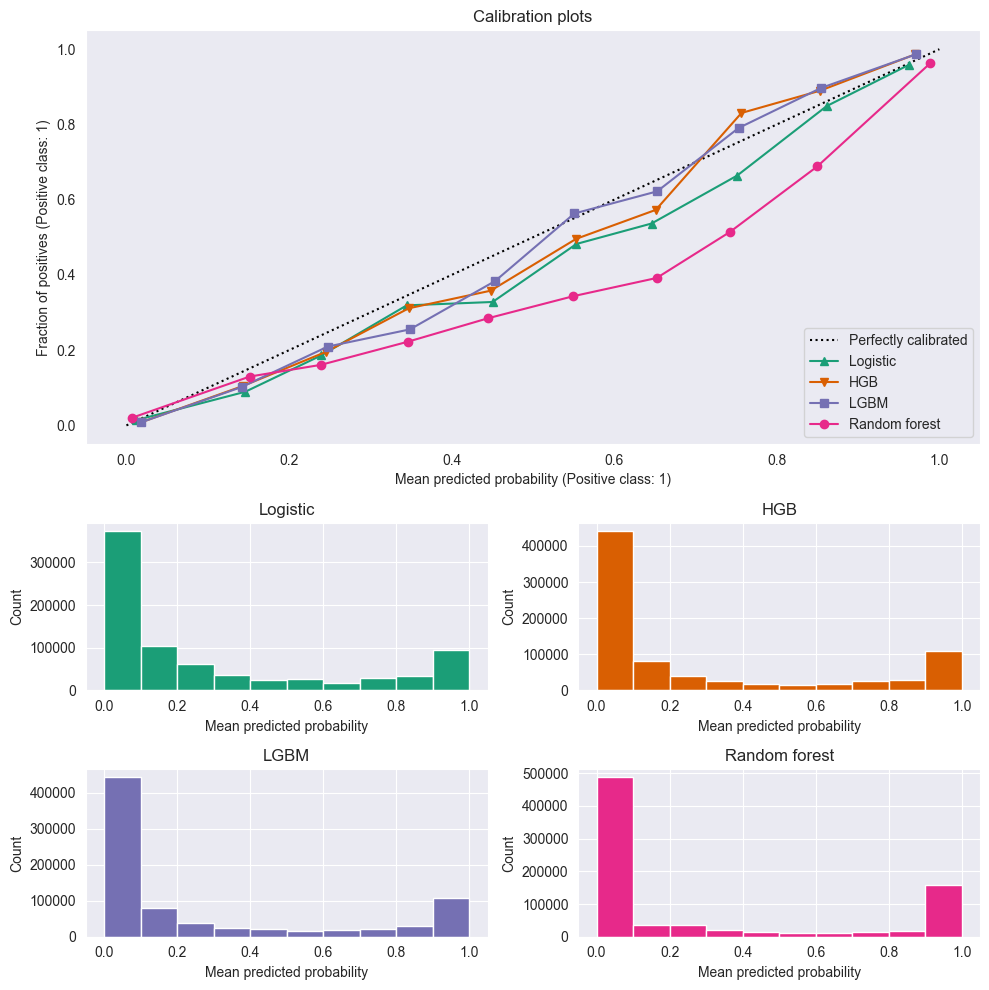

In [27]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_70210/2008148767.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pre

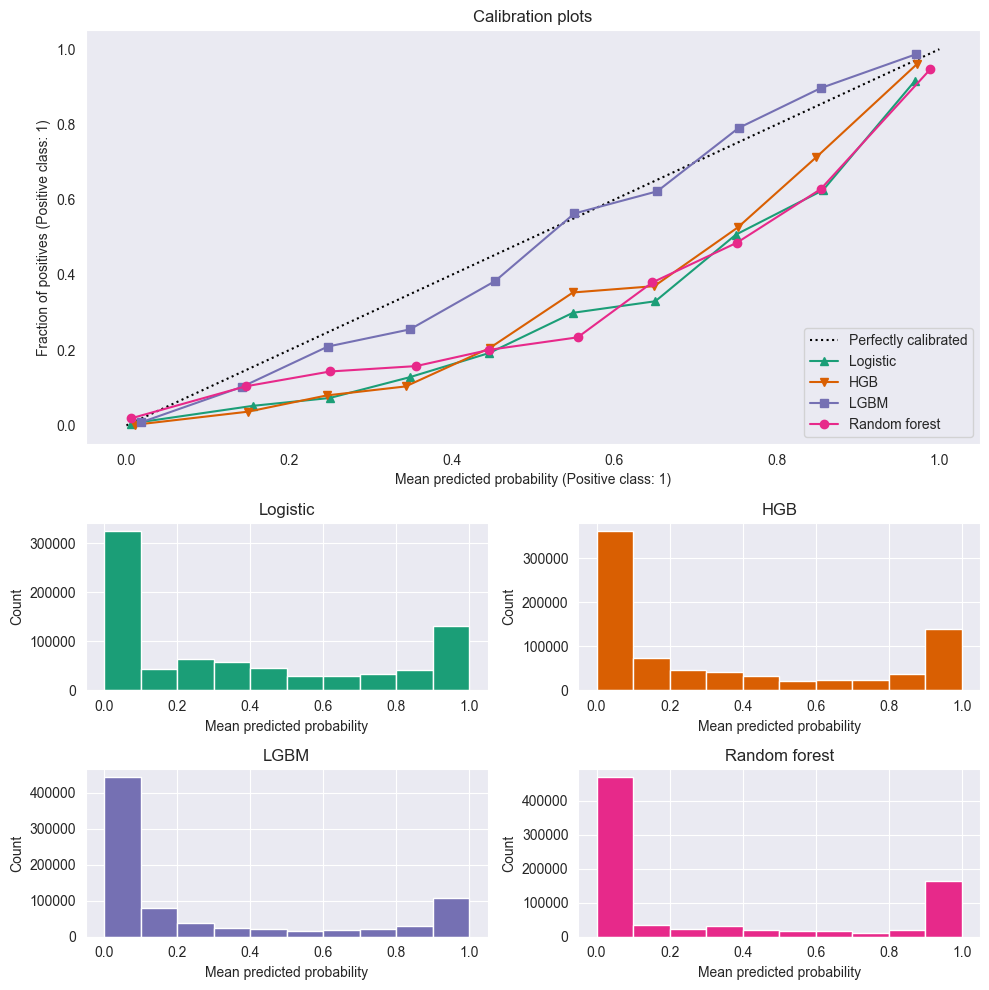

In [38]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()